In [35]:
import pandas as pd
import sqlalchemy as sa

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

In [20]:
engine = sa.create_engine(open("SQL_queries/engine.txt", 'r').read())

In [21]:
with engine.connect() as conn:
    tno_historical_admissions_df = pd.read_sql(open("SQL_queries\\tno_historical_admissions_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date

tno_historical_admissions_df

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_3700\1902730316.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_historical_admissions_df = pd.read_sql(open("SQL_queries\\tno_historical_admissions_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date


,SpellStartDate,em_el_dc,N
0,2022-01-02,EMERG,1
1,2022-01-03,EMERG,5
2,2022-01-04,EMERG,2
3,2022-01-05,EMERG,3
4,2022-01-06,EMERG,1
...,...,...,...
2903,2025-07-18,EMERG,6
2904,2025-07-18,ELECT,1
2905,2025-07-19,ELECT,4
2906,2025-07-19,EMERG,2


In [22]:
tno_historical_admissions_df["em_el_dc"] = tno_historical_admissions_df["em_el_dc"].fillna("EMERG")

In [23]:
tno_historical_admissions_df["SpellStartDate"] = pd.to_datetime(tno_historical_admissions_df["SpellStartDate"])

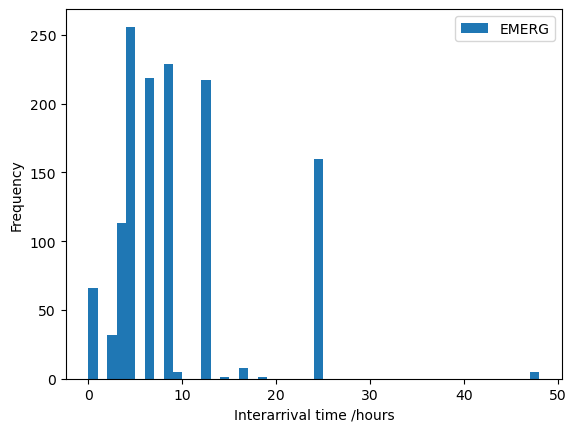

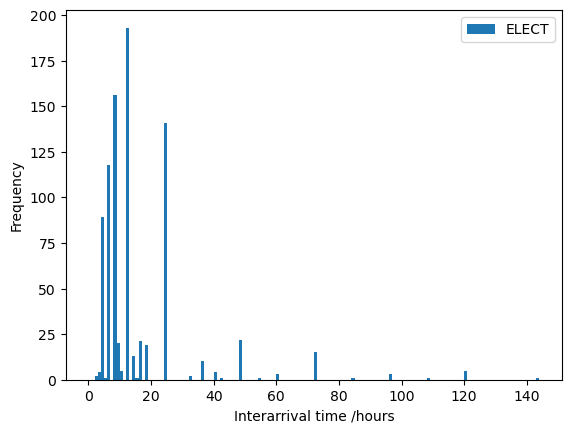

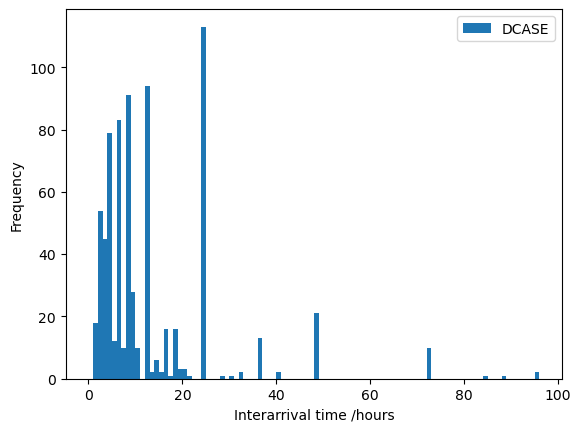

In [24]:
for urgency in tno_historical_admissions_df["em_el_dc"].unique():
    tmp_df = tno_historical_admissions_df.query(f'em_el_dc == "{urgency}"')
    iats = ((tmp_df["SpellStartDate"].diff() / pd.Timedelta(hours=1)) / tmp_df["N"])
    iats.plot.hist(bins=range(int(iats.max()+1)), label=urgency)
    plt.xlabel("Interarrival time /hours")
    plt.legend()
    plt.show()


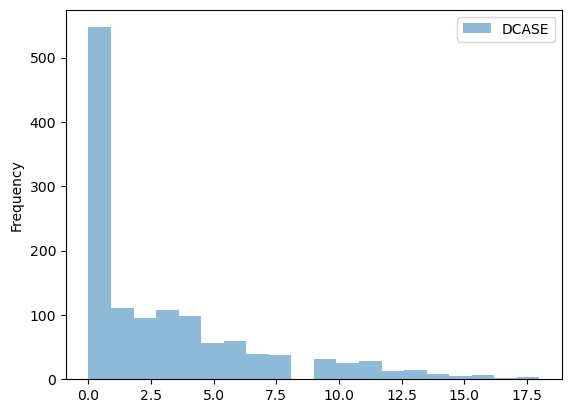

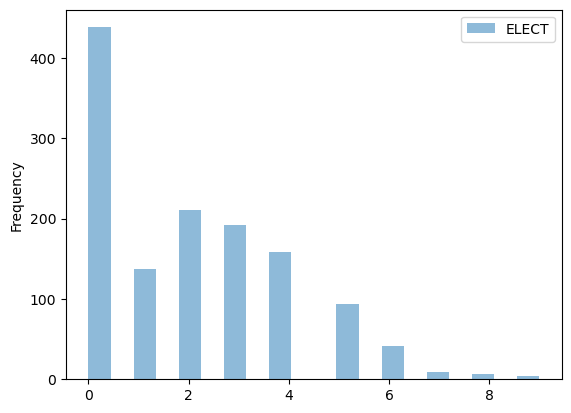

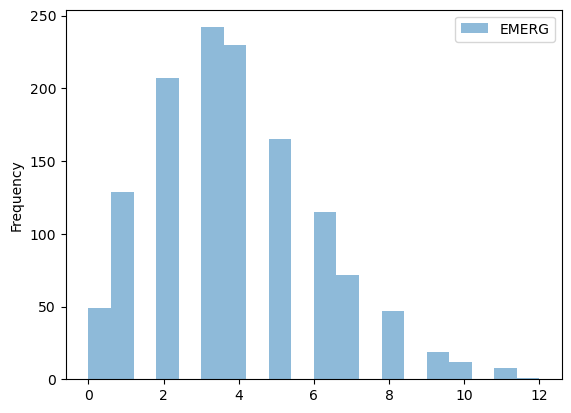

In [25]:
for urgency, urgency_df in tno_historical_admissions_df.groupby("em_el_dc"):
    urgency_df.groupby("SpellStartDate").sum()["N"].resample('d').sum().plot.hist(label=urgency, alpha=0.5, bins=20)
    plt.legend()
    plt.show()

### Wait list

In [26]:
with engine.connect() as conn:
    tno_wait_list_df = pd.read_sql(open("SQL_queries\\tno_wait_list.sql").read(), con=conn.connection) # This list is up-to-date

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_3700\3720879254.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_wait_list_df = pd.read_sql(open("SQL_queries\\tno_wait_list.sql").read(), con=conn.connection) # This list is up-to-date


In [27]:
tno_wait_list_df["ReferralUrgency"].value_counts()

ReferralUrgency
Routine                                        678
Urgent                                         348
4 - Routine                                    109
3B - 10-12 Weeks                                51
3A - 8-10 Weeks                                 42
2D - Within 4 weeks                             27
2B - 7-14 days                                   5
2C - 15-21 days                                  4
Rapid Access                                     2
Ca2d - Cancer within 4 weeks                     1
C4 - Choice, patient declining or deferring      1
Name: count, dtype: int64

In [28]:
tno_wait_list_df["em_el_dc"].value_counts()

em_el_dc
DCASE        685
Inpatient    583
Name: count, dtype: int64

Text(0.5, 0, 'days waited')

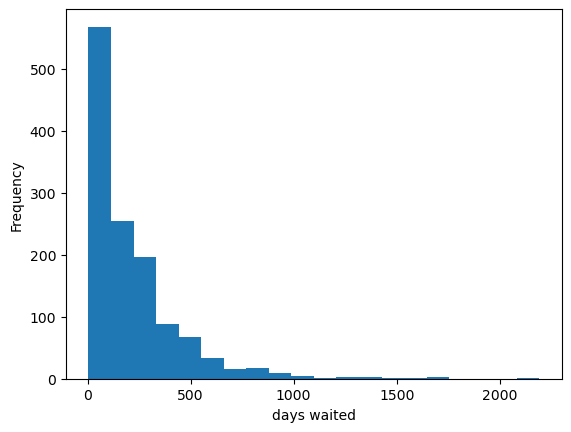

In [29]:
ax = (tno_wait_list_df["hours_waited"] / 24).plot.hist(bins=20)
ax.set_xlabel("days waited")

### Surgery duration

In [30]:
with engine.connect() as conn:
    tno_theatre_list_df = pd.read_sql(open("SQL_queries\\tno_surgery_durations_LR_edit.sql").read(), con=conn.connection)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_3700\2201337694.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_theatre_list_df = pd.read_sql(open("SQL_queries\\tno_surgery_durations_LR_edit.sql").read(), con=conn.connection)


In [31]:
tno_theatre_list_df["SchDur"] = pd.to_numeric(tno_theatre_list_df["SchDur"])

AdmissionType    0
SchDur           0
dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is 

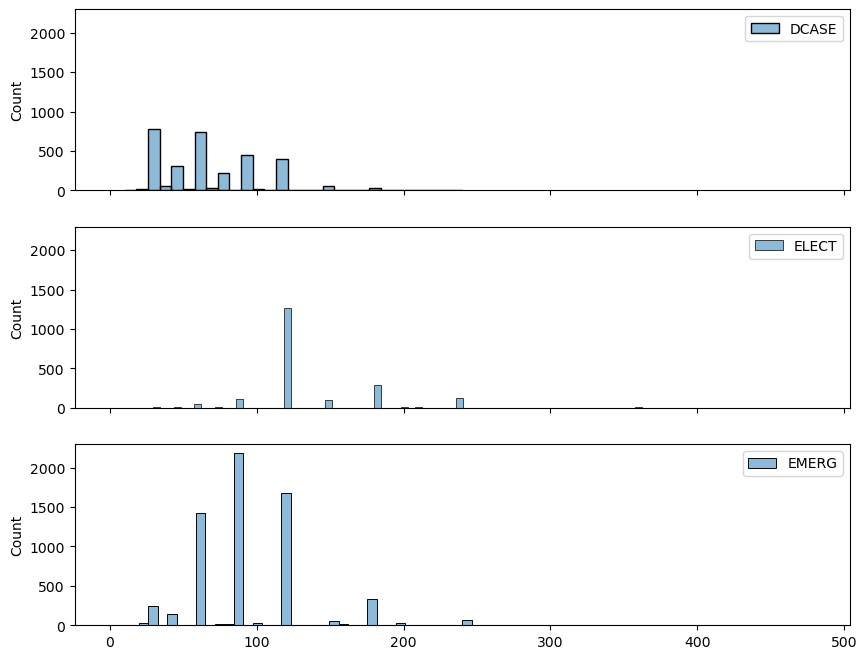

In [32]:
display(tno_theatre_list_df[["AdmissionType", "SchDur"]].isna().sum())

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(10)

for ax, (admission_type, schdur) in zip(axs, tno_theatre_list_df[["AdmissionType", "SchDur"]].dropna().groupby("AdmissionType")):
    sns.histplot(schdur, ax=ax, label=admission_type)
    ax.legend()

### LoS

AdmissionType     0
LoS              55
dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is 

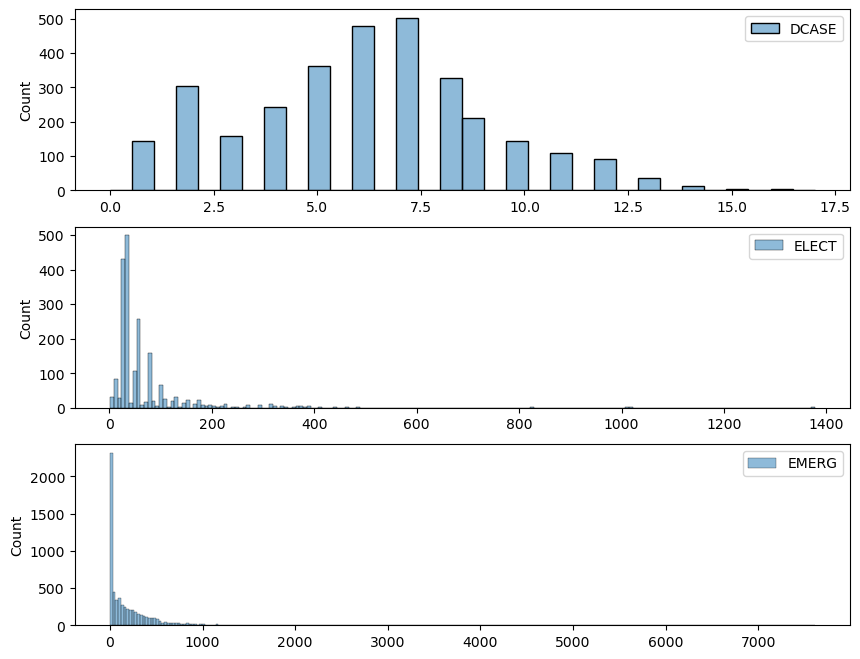

In [33]:
display(tno_theatre_list_df[["AdmissionType", "LoS"]].isna().sum())

fig, axs = plt.subplots(3, 1)
fig.set_figheight(8)
fig.set_figwidth(10)

for ax, (admission_type, schdur) in zip(axs, tno_theatre_list_df[["AdmissionType", "LoS"]].dropna().groupby("AdmissionType")):
    sns.histplot(schdur, ax=ax, label=admission_type)
    ax.legend()

In [36]:
emerg_los = tno_theatre_list_df[["AdmissionType", "LoS"]].dropna().query('AdmissionType == "EMERG"')
emerg_hist = np.histogram(emerg_los["LoS"], bins=range(0, int(emerg_los["LoS"].max())+1), density=True)
emerg_hist # TODO: do the same for elec and dcase

(array([0.        , 0.00015949, 0.00255183, ..., 0.        , 0.        ,
        0.00015949]),
 array([   0,    1,    2, ..., 7606, 7607, 7608]))

### Theatre Slots

In [37]:
with engine.connect() as conn:
    tno_theatre_slots_df = pd.read_sql(open("SQL_queries\\tno_theatre_slots_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_3700\413890781.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_theatre_slots_df = pd.read_sql(open("SQL_queries\\tno_theatre_slots_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date


In [38]:
tno_theatre_slots_df["SchDur"] = pd.to_numeric(tno_theatre_slots_df["SchDur"])

In [39]:
tno_theatre_slots_df["em_el_dc"] = tno_theatre_slots_df["em_el_dc"].fillna("EMERG")

In [40]:
min_date = tno_theatre_slots_df["SchSurgeryDate"].min()
em_el_dc_mapping = {"DCASE":"Daycase", "EMERG":"Emergency", "ELECT":"Elective", None:"Emergency"}

schedule = []

for date_room, theatre_slot_df in tno_theatre_slots_df.groupby(["SchSurgeryDate", "SchOperatingRoom"]):
    hours_remaining = theatre_slot_df["SchDur"].sum() / 60
    patient_type = em_el_dc_mapping[theatre_slot_df["em_el_dc"].mode()[0]]
    hour = ((date_room[0] - min_date) + pd.Timedelta(f"{theatre_slot_df['SchSurgeryTime'].min()}:00")) / pd.Timedelta(hours=1)
    schedule.append((hour, patient_type, hours_remaining, hours_remaining, []))

In [41]:
pd.DataFrame(schedule, columns=["hour", "patient_type", "hours_total", "hours_remaining", "patients"]).sort_values(by="hour")

,hour,patient_type,hours_total,hours_remaining,patients
2,9.0,Daycase,5.500000,5.500000,[]
3,9.0,Emergency,6.000000,6.000000,[]
1,9.5,Daycase,8.000000,8.000000,[]
0,14.0,Daycase,3.500000,3.500000,[]
4,33.0,Daycase,3.000000,3.000000,[]
5,33.0,Elective,6.500000,6.500000,[]
6,33.0,Elective,5.000000,5.000000,[]
7,33.0,Emergency,5.500000,5.500000,[]
11,57.0,Emergency,3.666667,3.666667,[]
10,57.0,Elective,7.000000,7.000000,[]


In [42]:
# TODO:
#  Verify delay between referral and appointments (look at the probability distribution)
#  Include some prioritisation within the scheduling
#  Examine wait times for appointments (+ increased capacity etc...) -- Use for validation too

#  Look at ratios of priorities, then book in based on closest to priority threshold? -- Look at wait list prioritisation